In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
color_pallet = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
from statsmodels.tsa.stattools import adfuller #Augumented Dickey Fuller Test 
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposing the Series into trend and seasonality
from statsmodels.tsa.stattools import acf , pacf #Observing Auto correlation and partial correlation function
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
# checking first few rows of train df
train_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [6]:
# checking first few rows of test df
test_df.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [7]:
# checking info of our train df
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [8]:
train_df.describe()

,store,product,number_sold
count,230090.000000,230090.000000,230090.000000
mean,3.000000,4.500000,780.926107
std,2.000004,2.872288,204.096737
min,0.000000,0.000000,238.000000
25%,1.000000,2.000000,722.000000
50%,3.000000,4.500000,835.000000
75%,5.000000,7.000000,914.000000
max,6.000000,9.000000,1205.000000


### we can see the type of date column is object type,lets change it to correct type

In [9]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
## changing column name from numbers_sold to sold
new_columns = ['Date','Store','Products','Sold']
train_df.columns = new_columns
test_df.columns = new_columns

In [10]:
# different types of stores available inour dataframe
train_df['Store'].value_counts()

0    32870
1    32870
2    32870
3    32870
4    32870
5    32870
6    32870
Name: Store, dtype: int64

In [11]:
# Different types of products available inour dataframe
train_df['Products'].value_counts()

0    23009
1    23009
2    23009
3    23009
4    23009
5    23009
6    23009
7    23009
8    23009
9    23009
Name: Products, dtype: int64

#### Extracting day ,month, year, day of week  from date column

In [12]:
train_df['day']= train_df['Date'].dt.day
train_df['month']= train_df['Date'].dt.month
train_df['year']= train_df['Date'].dt.year
train_df['dayofweek']= train_df['Date'].dt.dayofweek
test_df['day']= test_df['Date'].dt.day
test_df['month']= test_df['Date'].dt.month
test_df['year']= test_df['Date'].dt.year
test_df['dayofweek']= test_df['Date'].dt.dayofweek


In [13]:
train_df.head()

,Date,Store,Products,Sold,day,month,year,dayofweek
0,2010-01-01,0,0,801,1,1,2010,4
1,2010-01-02,0,0,810,2,1,2010,5
2,2010-01-03,0,0,818,3,1,2010,6
3,2010-01-04,0,0,796,4,1,2010,0
4,2010-01-05,0,0,808,5,1,2010,1


## Explanatory Data Analysis

#### Data distribution with respect to Store

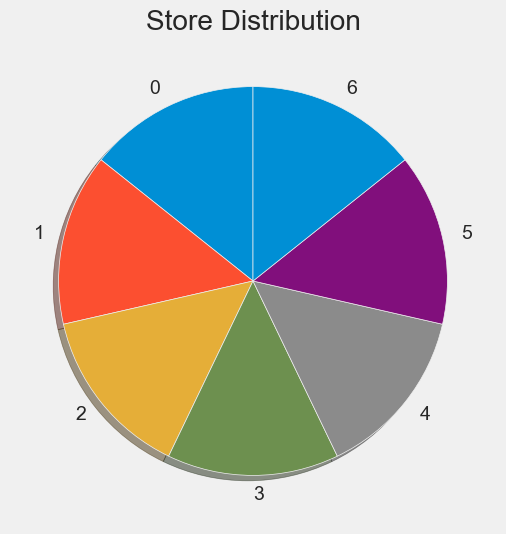

In [14]:
storeNames = train_df["Store"].unique()
storeCount = train_df["Store"].value_counts()

fig1, ax1 = plt.subplots(figsize=(6,6))
plt.pie(storeCount,
        labels=storeNames,
        startangle=90,
        shadow=True)
# Add title to graph
plt.title("Store Distribution")
# Draw the chart
plt.show()

### Store with maximum sales in a particular year

In [15]:
store_sale_yearwise = train_df[['Store','year','Sold']]
store_sale_yearwise.head()

,Store,year,Sold
0,0,2010,801
1,0,2010,810
2,0,2010,818
3,0,2010,796
4,0,2010,808


In [16]:
store_sale_yearwise['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

##### we can see our year column has 9 unique vales in year, we can use it to plot sales of each store for each year.lets 
##### define a function for the above.

In [17]:
def plot_storesale_year(store):
    """
    This function will take store type as input andcreate a dataframe for each store with thier sold values in each year .
    Then it will plot a line plot for that dataframe.
    """
    store_sale = pd.DataFrame(store_sale_yearwise[store_sale_yearwise['Store']==store].\
                      groupby('year').sum(['Sold']).reset_index())
    plt.figure(figsize =(8,6))
    store_sale.plot(x= 'year',y = 'Sold')
    plt.title('Plot of Amount Sold Each Year by Store {}'.format(store))
    plt.xlabel('Year',fontsize=14)
    plt.ylabel("Amount Sold",fontsize =14)
    plt.show();

<Figure size 800x600 with 0 Axes>

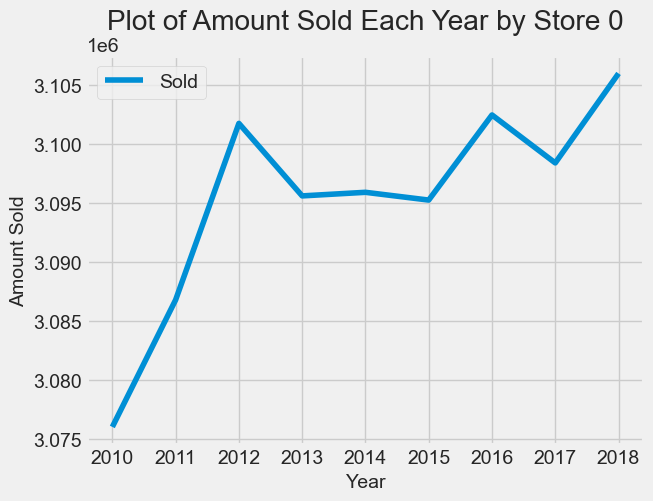

<Figure size 800x600 with 0 Axes>

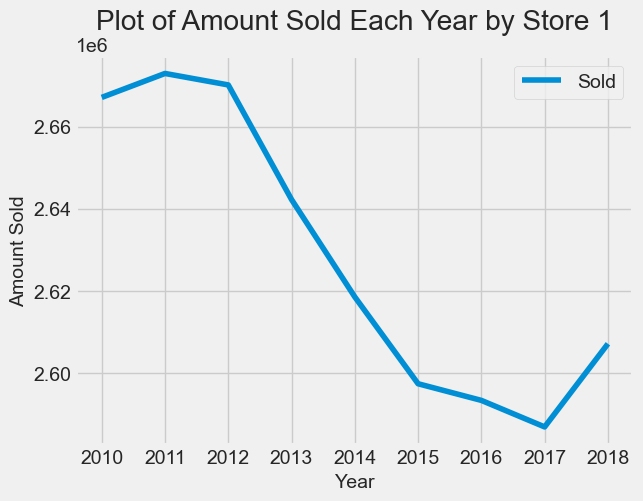

<Figure size 800x600 with 0 Axes>

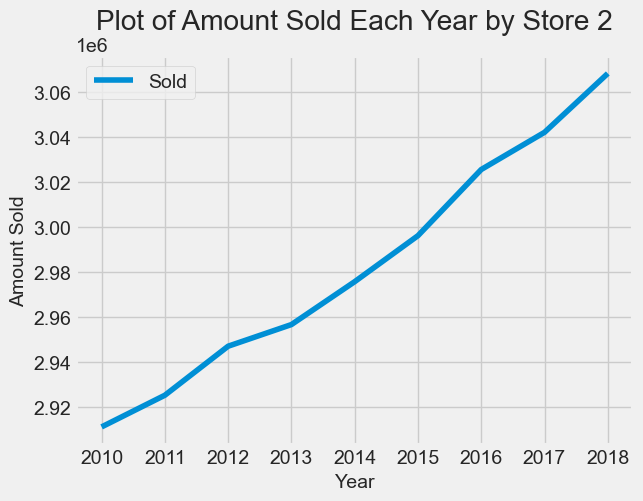

<Figure size 800x600 with 0 Axes>

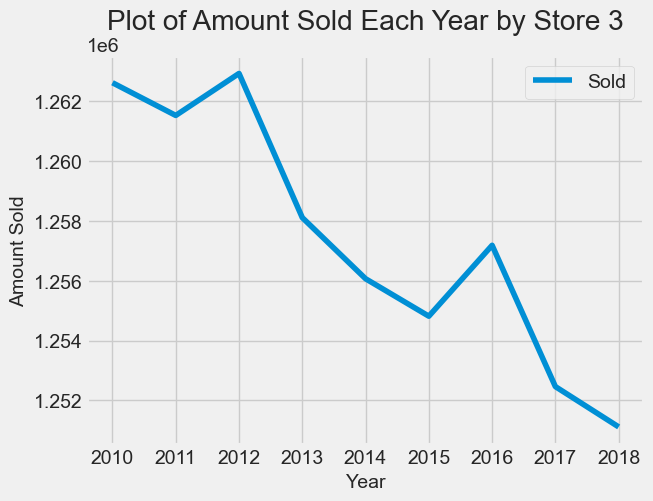

<Figure size 800x600 with 0 Axes>

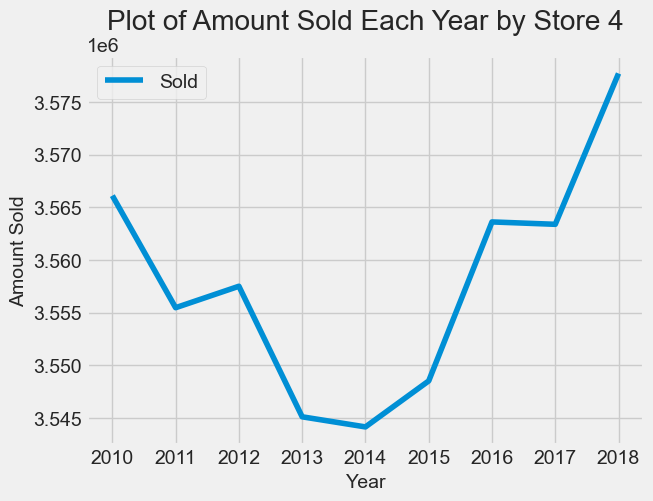

<Figure size 800x600 with 0 Axes>

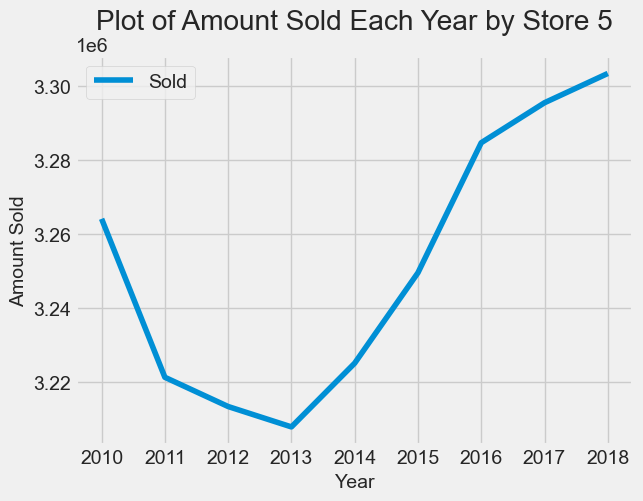

<Figure size 800x600 with 0 Axes>

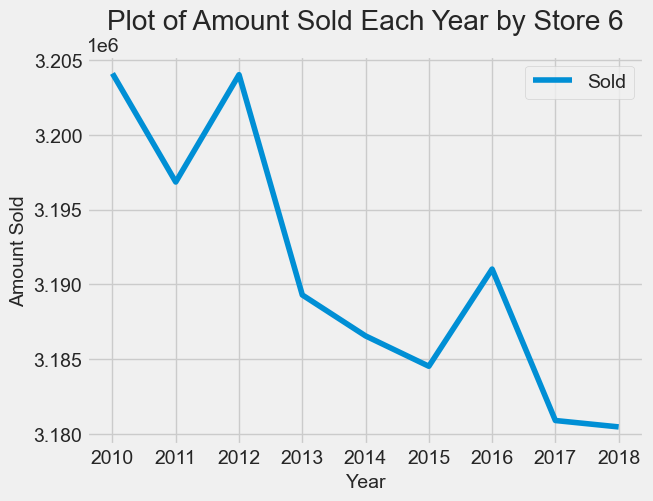

In [18]:
for i in range(train_df['Store'].nunique()):
    plot_storesale_year(i)
    print('')

### Which store has minimum and maximum sales?

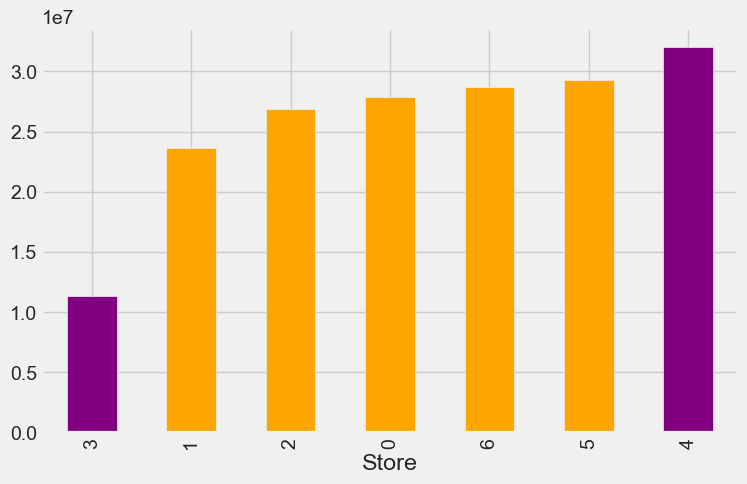

In [35]:
plt.figure(figsize = (8,5))

# Sum weekly sales for each store ,then sorted by total sales
total_sales_for_each_store = train_df.groupby('Store')['Sold'].sum().sort_values()
total_sales_for_each_store_array = np.array(total_sales_for_each_store)  # convert to array

# Assigning a specific color for the stores have the lowest and highest sales
clrs = ['orange' if ((x < max(total_sales_for_each_store_array)) and (x > min(total_sales_for_each_store_array)))
         else 'purple' for x in total_sales_for_each_store_array]

ax = total_sales_for_each_store.plot(kind='bar',color=clrs);         

##### from the above graph we can seee that store ('3') have minimum sales and store('4') have maximum sales

In [41]:
monthly_sales = train_df.groupby(['Store','month'])['Sold'].sum().sort_values(ascending = False).reset_index()

In [79]:
def plot_storesale_month(store):
    """
    This function will take store type as input andcreate a dataframe for each store with thier sold values in each month .
    Then it will plot a bar plot for that dataframe.
    """
    monthly_sales = pd.DataFrame(train_df.groupby(['Store','month'])['Sold'].sum().\
                                 sort_values(ascending = False).reset_index())
    monthly_sales_of_store = monthly_sales[monthly_sales['Store']==store]                             
    plt.figure(figsize =(3,3))
    monthly_sales_of_store.plot(kind = 'bar',x= 'month',y = 'Sold')
    plt.title('Plot of Amount Sold Each month by Store {}'.format(store))
    plt.xlabel('Month',fontsize=10)
    plt.ylabel("Amount Sold",fontsize =10)
    plt.show();

<Figure size 300x300 with 0 Axes>

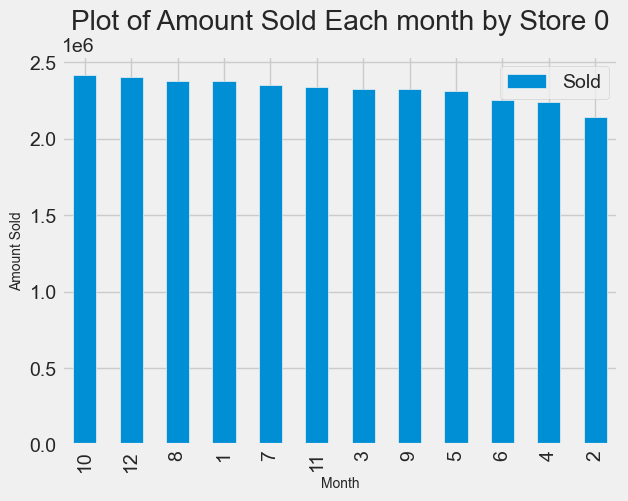

<Figure size 300x300 with 0 Axes>

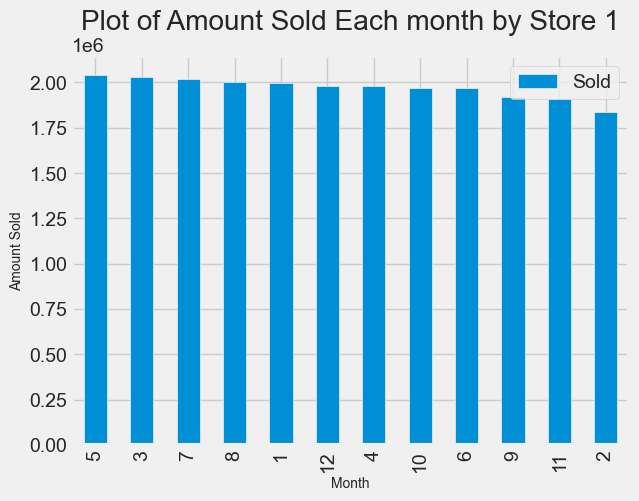

<Figure size 300x300 with 0 Axes>

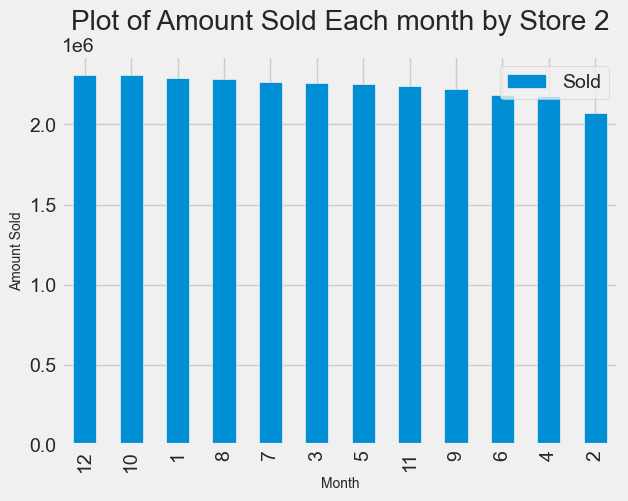

<Figure size 300x300 with 0 Axes>

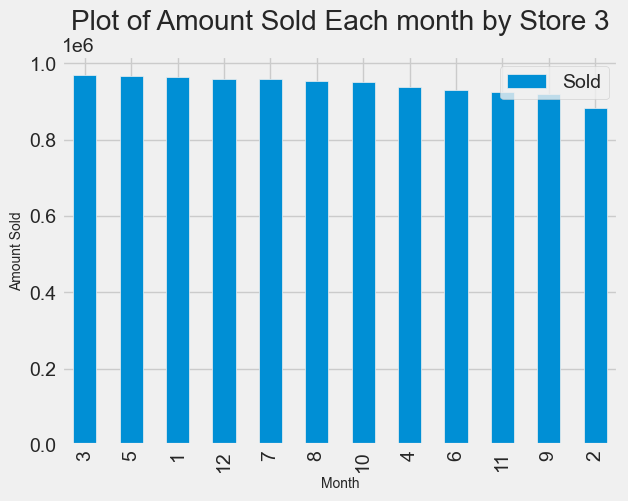

<Figure size 300x300 with 0 Axes>

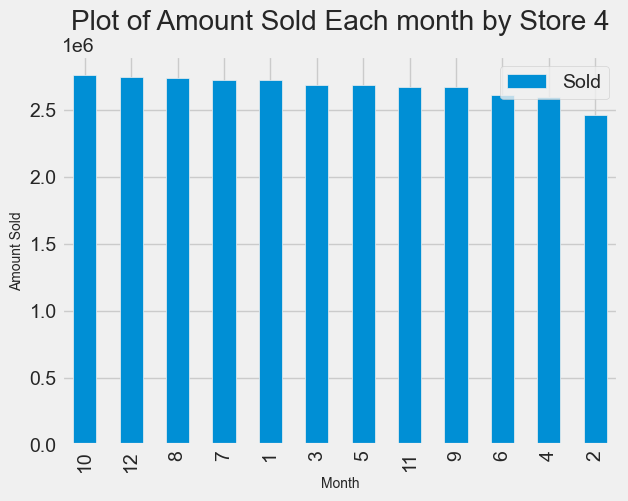

<Figure size 300x300 with 0 Axes>

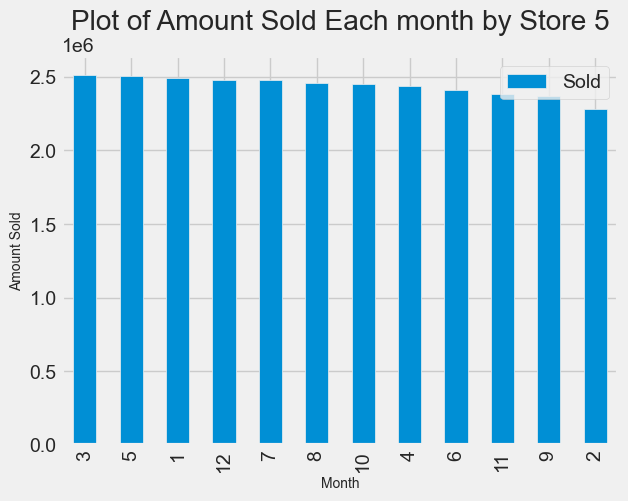

<Figure size 300x300 with 0 Axes>

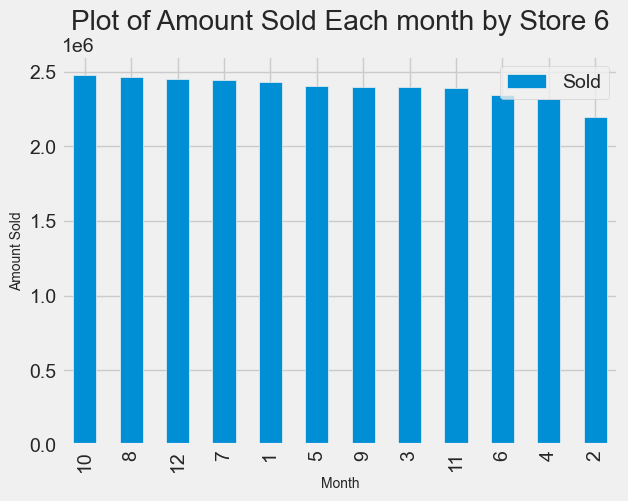

In [80]:
for i in range(train_df['Store'].nunique()):
    plot_storesale_month(i)
    print('')

### We will deal with each store individually

## Store 1

In [19]:
train_df.set_index('Date', inplace= True)

In [20]:
train_df.head()

,Store,Products,Sold,day,month,year,dayofweek
Date,,,,,,,
2010-01-01,0,0,801,1,1,2010,4
2010-01-02,0,0,810,2,1,2010,5
2010-01-03,0,0,818,3,1,2010,6
2010-01-04,0,0,796,4,1,2010,0
2010-01-05,0,0,808,5,1,2010,1


### 1st product

In [21]:
## Store with product id 0
s1p1 =train_df[(train_df['Store']==0) & (train_df['Products']==0)]
s1p1.head()

,Store,Products,Sold,day,month,year,dayofweek
Date,,,,,,,
2010-01-01,0,0,801,1,1,2010,4
2010-01-02,0,0,810,2,1,2010,5
2010-01-03,0,0,818,3,1,2010,6
2010-01-04,0,0,796,4,1,2010,0
2010-01-05,0,0,808,5,1,2010,1


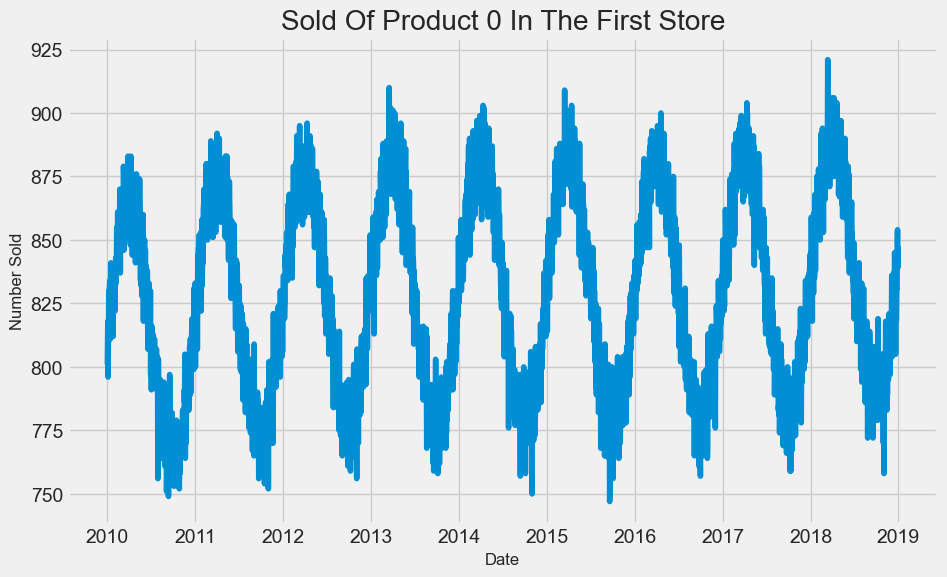

In [22]:
plt.figure(figsize = (10, 6))
plt.plot(s1p1.index, s1p1['Sold'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Number Sold', {'fontsize': 12})
plt.title('Sold Of Product 0 In The First Store')
plt.show()
       

#### Analysis

From the above graph as we can see , sale of products '0' have been very stationary in the given time period.

### Ways to check if the given data is Stationery

### We can check whether a given time series is stationery or not using 2 tests , namely

1. Rolling Statistics

2. Augumented Dickey Fuller Test

### Rolling Statistics

This is more of a visual test

Here , we simply plot the moving average or variance of the given time series and try to observe if the plotted varies a lot with time

If average and variance do not change much with time , then our time series is stationery

In [23]:
average = s1p1['Sold'].dropna().rolling(window = 12).mean() #Rolling Average year
std = s1p1['Sold'].dropna().rolling(window = 12).std() #Rolling Standard Deviation

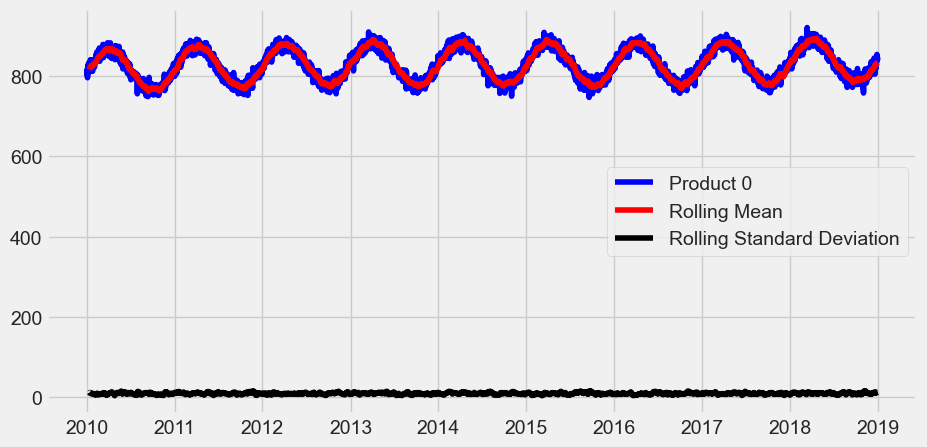

In [24]:
plt.figure(figsize = (10 , 5))
plt.plot(s1p1.index, s1p1['Sold'],c = 'b',label='Product 0')
plt.plot(average , c = 'r' , label = 'Rolling Mean' )
plt.plot(std , c = 'black' , label = 'Rolling Standard Deviation')
plt.legend()

#### It is clearly observable from the above Test that the given time series data is close to being stationary


### Let us scientifically confirm our above claim by using the famous Augumented Dickey Fuller Test

Augumented Dickey Fuller Test (ADF)

Let us assume a NULL Hypothesis H0 that the given time series is not stationary

Check the test statistic and values for different confidence intervals

If test statistic is < alpha value, reject the H0

Here , we take our confidence interval to be 95%

In [25]:
adf_test = adfuller(s1p1['Sold'])

In [26]:
print("Test Statistic : " , adf_test[0])
print("P Value : " , adf_test[1])

Test Statistic :  -5.05146490745594
P Value :  1.7536429088010104e-05


As our alpha value is 0.05 , and as p - value is  less than .05 , we not fail to reject our null hypotheses(N0)

Hence , we can now definitely confirm that our time series is  stationery.